In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

import time
import os
import cv2
print(tf.__version__)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

2.0.0-alpha0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
POS_TARGET_DIR = './data/processed/present'
NEG_TARGET_DIR = './data/processed/empty'
IMG_DIR = './data/processed'
T_WIDTH = 58
T_HEIGHT = 100

In [4]:
def strong_aug(p=.5):
    return Compose([
        Flip(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.3),
            MedianBlur(blur_limit=3, p=0.2),
            Blur(blur_limit=3, p=0.2),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.2),
            IAAPiecewiseAffine(p=0.2),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.5),
        HueSaturationValue(p=0.3),
    ], p=p)

def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=15, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

In [5]:
def load_images_from_path(path):
    ds = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, (T_WIDTH, T_HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ds.append(img)
    return ds

In [ ]:
pos_images = load_images_from_path(POS_TARGET_DIR)
neg_images = load_images_from_path(NEG_TARGET_DIR)

In [ ]:
X_pos = np.array(pos_images) / 255.
X_neg = np.array(neg_images) / 255.
y_pos = np.ones(X_pos.shape[0])
y_neg = np.zeros(X_neg.shape[0])
X = np.concatenate([X_pos, X_neg])
y = np.concatenate([y_pos, y_neg])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
aug = augment_flips_color(p=1)
def aug_wrapper(img):
    return aug(image=img)

In [ ]:
pool = Pool(processes=30)

pos_images_aug = [el['image'] for el in pool.map(aug_wrapper, pos_images)]
neg_images_aug = [el['image'] for el in pool.map(aug_wrapper, neg_images)]
pool.close()

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2408, 100, 58, 3), (602, 100, 58, 3), (2408,), (602,))

In [ ]:
X_pos_aug = np.array(pos_images_aug) / 255.
X_neg_aug = np.array(neg_images_aug) / 255.
y_pos_aug = np.ones(X_pos_aug.shape[0])
y_neg_aug = np.zeros(X_neg_aug.shape[0])
X_train_aug = np.concatenate([X_train, X_pos_aug, X_neg_aug])
y_train_aug = np.concatenate([y_train, y_pos_aug, y_neg_aug])
X, y = shuffle(X, y)

In [ ]:
X_train_aug.shape, y_train_aug.shape

((5418, 100, 58, 3), (5418,))

0.0


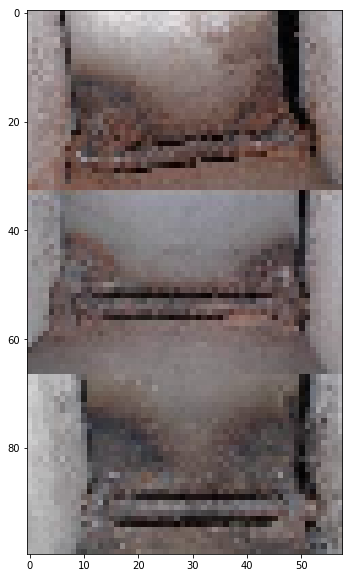

0.0


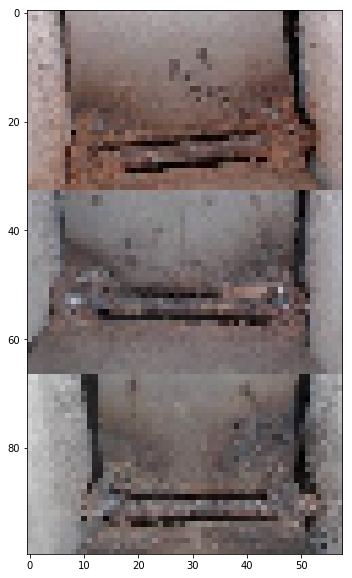

0.0


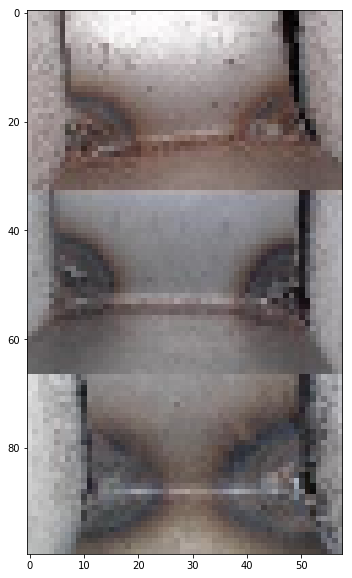

1.0


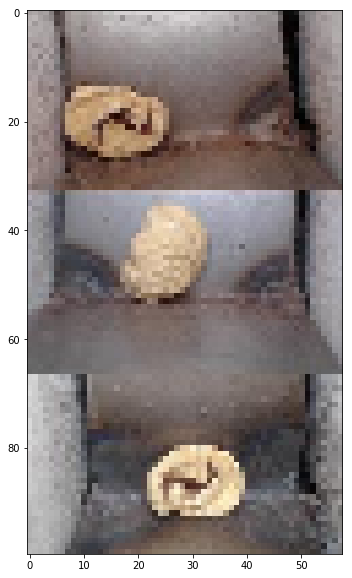

1.0


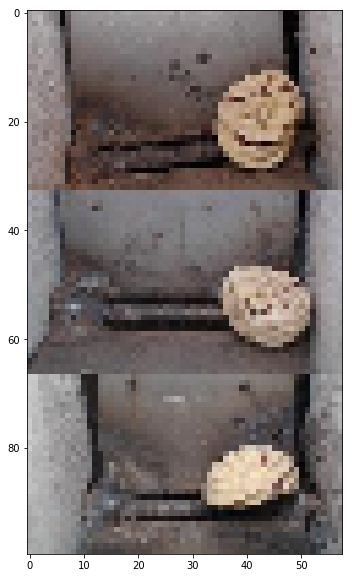

1.0


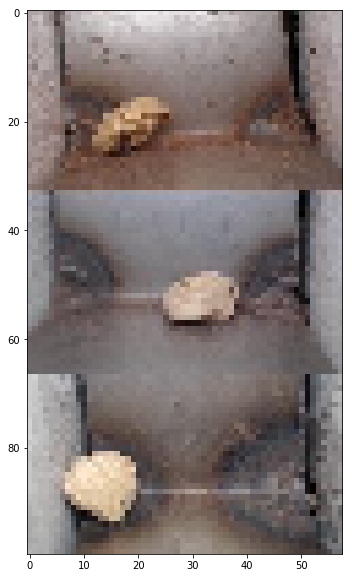

1.0


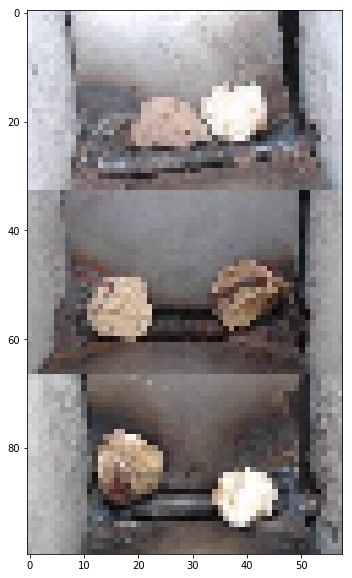

1.0


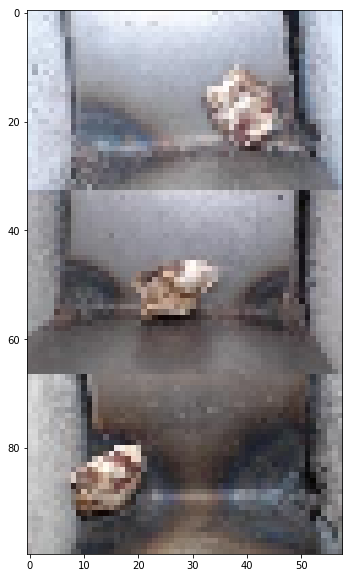

1.0


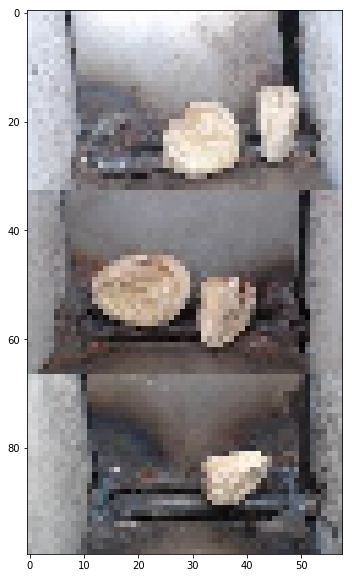

0.0


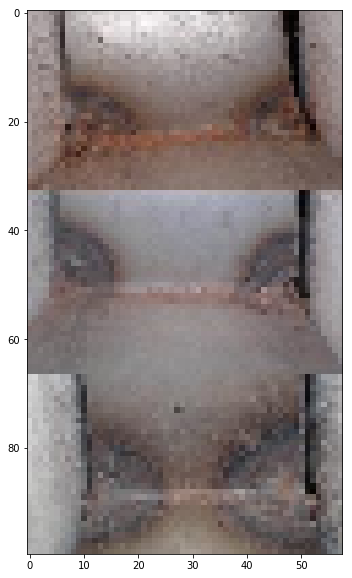

1.0


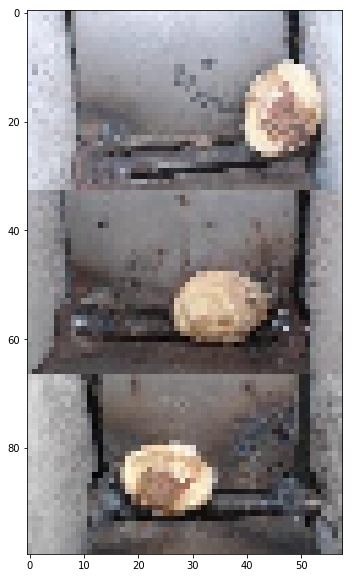

0.0


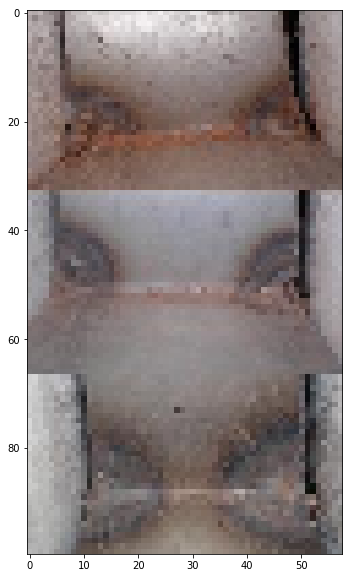

0.0


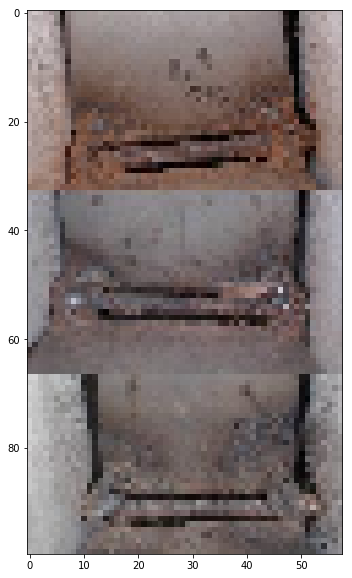

1.0


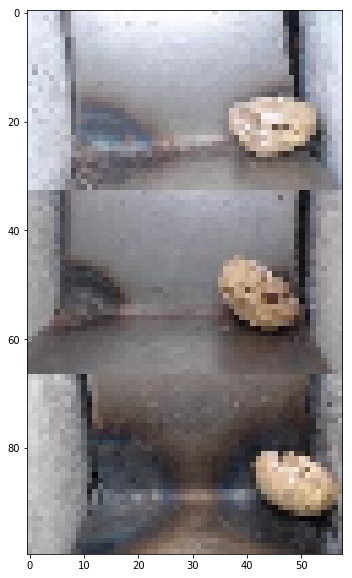

1.0


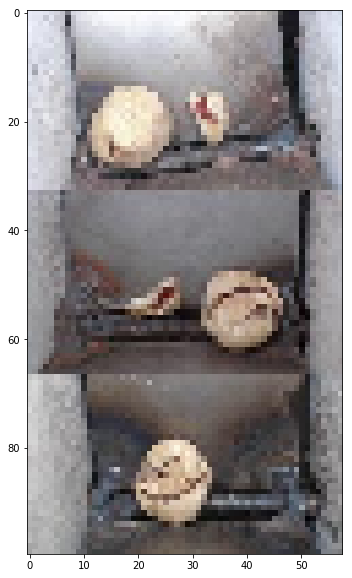

0.0


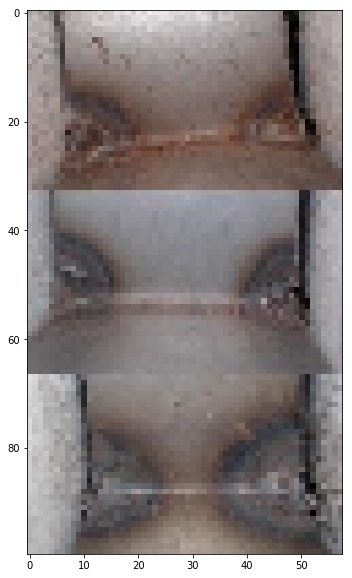

1.0


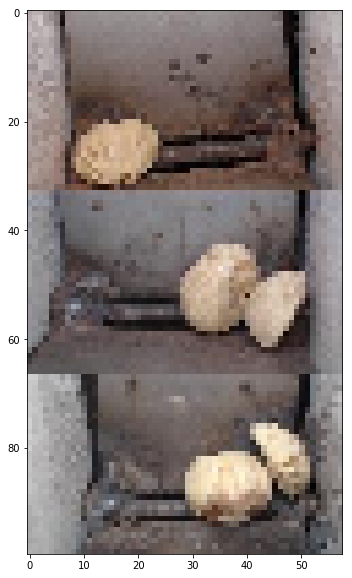

1.0


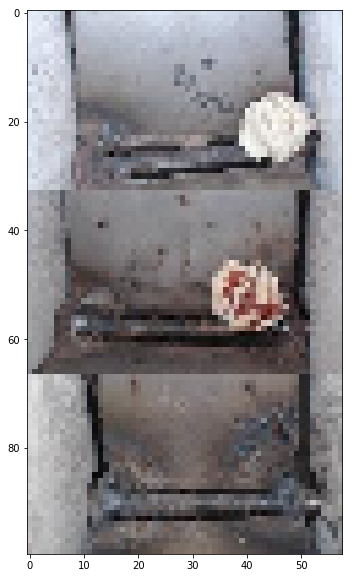

0.0


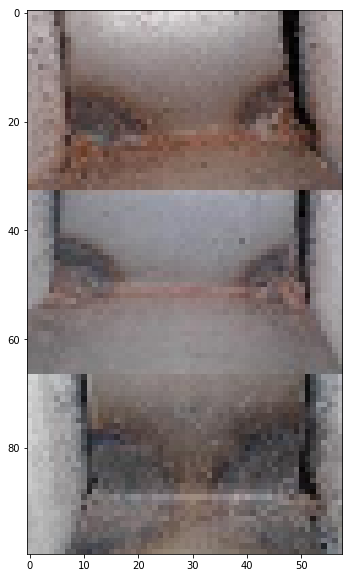

0.0


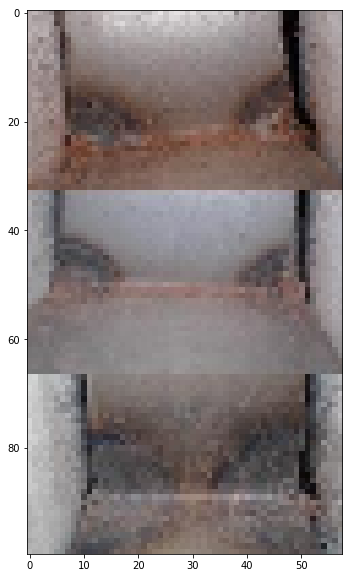

In [ ]:
# img = cv2.cvtColor(neg_images[1844],cv2.COLOR_BGR2RGB)
for i in range(20):
    img = X_train[i]
    print(y_train[i])
    # img = cv2.resize(img, (175, 300))
    plt.imshow(img)
    plt.show()

In [ ]:
image_input = tf.keras.Input(shape=(T_HEIGHT, T_WIDTH, 3), name='input_layer')

# Some convolutional layers
conv_1 = keras.layers.Conv2D(32,
                                kernel_size=(5, 5),
                                padding='same',
                                activation='relu')(image_input)
conv_1 = keras.layers.MaxPooling2D(padding='same')(conv_1)
conv_2 = keras.layers.Conv2D(32,
                                kernel_size=(4, 4),
                                padding='same',
                                activation='relu')(conv_1)
conv_2 = keras.layers.MaxPooling2D(padding='same')(conv_2)
conv_3 = keras.layers.Conv2D(32,
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu')(conv_1)
conv_3 = keras.layers.MaxPooling2D(padding='same')(conv_2)

# Flatten the output of the convolutional layers
conv_flat = keras.layers.Flatten()(conv_3)

# Some dense layers with two separate outputs
fc_1 = keras.layers.Dense(64,
                             activation='relu')(conv_flat)
fc_1 = keras.layers.Dropout(0.3)(fc_1)
fc_2 = keras.layers.Dense(64,
                             activation='relu')(fc_1)
fc_2 = keras.layers.Dropout(0.3)(fc_2)

# Output layers: separate outputs for the weather and the ground labels
output = keras.layers.Dense(2,
                            activation='softmax',
                            name='output')(fc_2)
model = tf.keras.Model(inputs=image_input, outputs=[output])

In [ ]:
model.summary()

In [ ]:
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer='adam',
              loss={'output': 'binary_crossentropy'},
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))


In [ ]:
X_train.shape, y_train.shape
print(y_train)

y_train_cat = keras.utils.to_categorical(y_train_aug, num_classes=2)
y_test_cat =  keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc')

In [16]:
model.fit(X_train_aug, y_train_cat, 
          validation_split=0.1, 
          batch_size=32, 
          epochs=8, 
          verbose=1, 
          shuffle=True,
          callbacks=[tensorboard])

Train on 4876 samples, validate on 542 samples
Epoch 1/8
4876/4876 [==============================] - 4s 916us/step - loss: 0.3176 - acc: 0.8534 - val_loss: 0.4035 - val_acc: 0.8432
Epoch 2/8
4876/4876 [==============================] - 3s 525us/step - loss: 0.1288 - acc: 0.9580 - val_loss: 0.0973 - val_acc: 0.9797
Epoch 3/8
4876/4876 [==============================] - 3s 523us/step - loss: 0.0813 - acc: 0.9735 - val_loss: 0.1430 - val_acc: 0.9483
Epoch 4/8
4876/4876 [==============================] - 3s 515us/step - loss: 0.0633 - acc: 0.9824 - val_loss: 0.0464 - val_acc: 0.9889
Epoch 5/8
4876/4876 [==============================] - 3s 558us/step - loss: 0.0519 - acc: 0.9844 - val_loss: 0.0350 - val_acc: 0.9834
Epoch 6/8
4876/4876 [==============================] - 2s 510us/step - loss: 0.0472 - acc: 0.9840 - val_loss: 0.0219 - val_acc: 0.9908
Epoch 7/8
4876/4876 [==============================] - 3s 559us/step - loss: 0.0424 - acc: 0.9848 - val_loss: 0.0094 - val_acc: 0.9982
Epoch 8/

In [17]:
model.evaluate(X_test, y_test_cat, batch_size=512)

602/602 [==============================] - 0s 511us/step


[0.02069196827783933, 0.9950166069391954]

In [18]:
model.save('detect_empty.h5')

In [23]:
del model

In [ ]:
model = keras.models.load_model('detect_empty.h5')

In [ ]:
y_pred_cat = model.predict(X_test, batch_size=256)
y_pred_cat

In [ ]:
y_pred = np.argmax(y_pred_cat, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
labels = im[1]
images = im[0]

In [ ]:
labels.shape

In [ ]:
labels[1] == float(0)

In [ ]:
labels = labels.astype(int)

In [ ]:
l0 = model.layers[0]
l0.get_config()

In [ ]:
np.where(labels == 0)

In [ ]:
# Look at samples from each class
MAX = 100
label = 0
elements = np.where(labels == label)[0]
np.random.shuffle(elements)
for c, id in enumerate(elements):
    print("Id: {}, Label: {}".format(id, labels[id]))
    plt.imshow(images[id])
    plt.show()
    if c > MAX:
        break
    

In [ ]:
nb_epochs = 60

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[tensorboard])

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

In [ ]:
with tf.Session() as sess:
  devices = sess.list_devices()

In [ ]:
devices

In [ ]:
K.clear_session()

In [ ]:
import tqdm
import time
for i in tqdm.tqdm(range(100)):
    time.sleep(1)